In [100]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE


In [101]:
df = pd.read_csv('/Users/jacksonsorenson/Documents/Pyhton Projects/Logistic Regression MArketing/CSV/Marketingcampaigns.csv')
df.head()

,Customer id,Age,Gender,Location,Email Opened,Email Clicked,Product page visit,Discount offered,Purchased
0,1,22,0,Perth,1,1,3,1,1
1,2,55,0,Auckland,1,0,0,0,0
2,3,15,1,Sydney,0,1,2,1,1
3,4,25,0,Brisbane,1,1,5,1,0
4,5,36,1,Brisbane,0,1,1,1,0


In [102]:
df = df.dropna()

In [103]:
# Feature Engineering

df['email_interaction'] = df['Email Opened'] * df['Email Clicked']
df['discount_effect'] = df['Discount offered'] * df['Product page visit']

In [104]:
df = pd.get_dummies(df, columns=['Location'], drop_first=True)


In [105]:
def generate_synthetic_data(df, num_samples=500):
    """
    Creates synthetic customer data using Gaussian & Random Sampling.
    """
    synthetic_data = pd.DataFrame()

    # Generate synthetic ages based on normal distribution (mean and std of real data)
    synthetic_data['Age'] = np.random.normal(df['Age'].mean(), df['Age'].std(), num_samples).astype(int)

    # Randomly assign gender (based on existing ratio)
    synthetic_data['Gender'] = np.random.choice(df['Gender'].unique(), num_samples, p=df['Gender'].value_counts(normalize=True))

    # Randomly assign email interactions
    synthetic_data['Email Opened'] = np.random.choice([0, 1], num_samples, p=[0.4, 0.6])
    synthetic_data['Email Clicked'] = np.random.choice([0, 1], num_samples, p=[0.7, 0.3])

    # Product page visits follow a similar distribution
    synthetic_data['Product page visit'] = np.random.normal(df['Product page visit'].mean(), df['Product page visit'].std(), num_samples).astype(int)
    synthetic_data['Product page visit'] = synthetic_data['Product page visit'].clip(lower=0)  # Ensure non-negative

    # Discount offered (use same probability distribution)
    synthetic_data['Discount offered'] = np.random.choice(df['Discount offered'].unique(), num_samples, p=df['Discount offered'].value_counts(normalize=True))

    # Interaction features
    synthetic_data['email_interaction'] = synthetic_data['Email Opened'] * synthetic_data['Email Clicked']
    synthetic_data['discount_effect'] = synthetic_data['Discount offered'] * synthetic_data['Product page visit']

    return synthetic_data

# Generate & Append Synthetic Data
X_synthetic = generate_synthetic_data(df, num_samples=500)


### --- GENERATE SYNTHETIC Y --- ###
# Generate synthetic target labels based on existing `Purchased` distribution
purchase_prob = df['Purchased'].value_counts(normalize=True)
y_synthetic = np.random.choice(df['Purchased'].unique(), 500, p=[purchase_prob[0], purchase_prob[1]])

# Convert to Pandas Series
y_synthetic = pd.Series(y_synthetic, name="Purchased")

# Concatenate synthetic and real data
X = pd.concat([X, X_synthetic], ignore_index=True)
y = pd.concat([y, y_synthetic], ignore_index=True)

# Verify shapes before splitting
print(f"Shape of X: {X.shape}")  # Should match y
print(f"Shape of y: {y.shape}")  # Should match X


Shape of X: (1020, 8)
Shape of y: (1020,)


In [106]:
X = df[['Age', 'Gender', 'Email Opened', 'Email Clicked', 'Product page visit', 
        'Discount offered', 'email_interaction', 'discount_effect']]
y = df['Purchased']

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [108]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [109]:
# SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [110]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [111]:
y_pred = model.predict(x_test)

In [112]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(report)

Accuracy: 0.25
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.00      0.00      0.00         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4



In [117]:
# Random Forrest Regression with Gridsearch

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth':[5,10,None],
    'min_samples_split':[2,5,10]
}
# Set up GridSearchCV with the correct parameters
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_params, cv=5, n_jobs=-1)

# Fit the model on resampled training data
grid_rf.fit(x_train_resampled, y_train_resampled)

# Get the best model from GridSearchCV
best_rf = grid_rf.best_estimator_

# Make predictions
y_pred_rf = best_rf.predict(x_test)

# Print results
print("\nRandom Forest Classifier (Optimized) Results:")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier (Optimized) Results:
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



In [118]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(x_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(x_test)

print("\nXGBoost Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(classification_report(y_test, y_pred_xgb))



XGBoost Classifier Results:
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


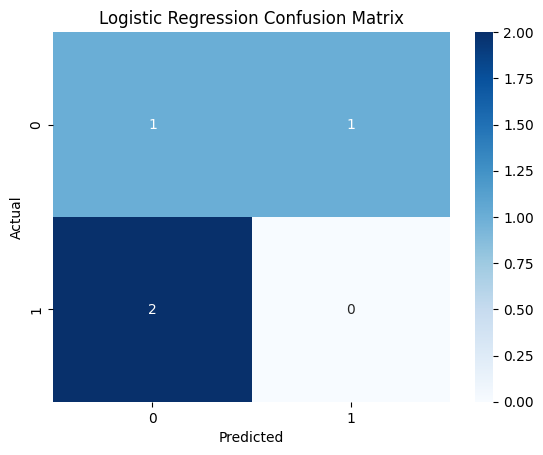

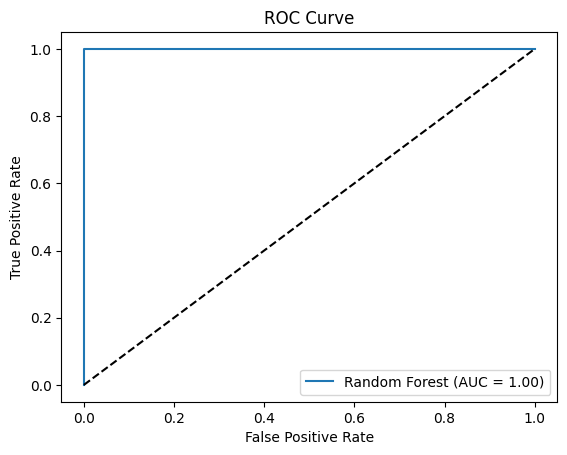

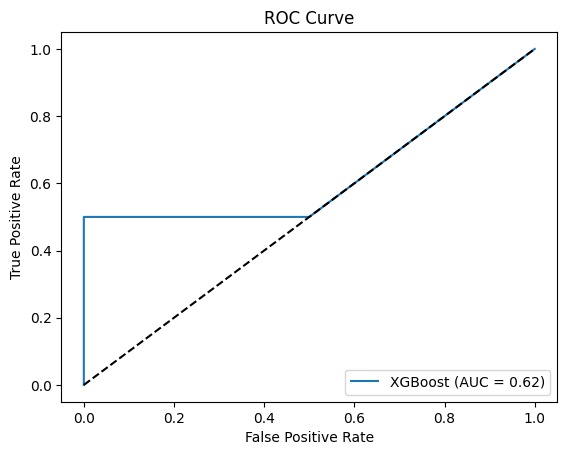

In [121]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Confusion Matrices
plot_confusion_matrix(y_test, y_pred, "Logistic Regression Confusion Matrix")

def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# ROC Curves
y_pred_rf_proba = best_rf.predict_proba(x_test)[:, 1]
plot_roc_curve(y_test, y_pred_rf_proba, "Random Forest")

y_pred_xgb_proba = xgb_model.predict_proba(x_test)[:, 1]
plot_roc_curve(y_test, y_pred_xgb_proba, "XGBoost")